# Parcellating the parcellation issue

The 38 papers of the 2017 Neuroimage special issue on brain parcellation and segmentation provide a snapshot of a vibrant area of neuroimaging research. Parcellation, segmentation, clustering, community detection, etc., are different names for techniques aimed at dividing a collection of examples into subsets with similar statistical properties. Although clustering methods are used to solve seemingly disparate problems in neuroimaging, they all share the common goal of providing a broad understanding of the data, while abstracting away less relevant finer-grained information. So when the time came to write this editorial, we could not resist using a cluster analysis to organize these 38 papers into data-driven categories. 

In [1]:
# Import a set of python tools, drawn from the jupyter data-science-notebooks docker stack
# https://github.com/jupyter/docker-stacks
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud

In [2]:
np.random.seed(0)

# Get the data
We first assembled the title, the name of the corresponding author, and the abstract for all the articles into a tabular-separated values (tsv) file, which we publicly archived on [Figshare](https://doi.org/10.6084/m9.figshare.5497468.v2). The following URL request is simply retrieving these data and loading them using pandas:

In [3]:
# Download the tsv file from the web
urllib.request.urlretrieve("https://ndownloader.figshare.com/files/9843721","YNIMG_BrainParcellation_summary.tsv")
# Read the tsv file with pandas
data = pd.read_csv('YNIMG_BrainParcellation_summary.tsv', sep='\t',header=0)
# Show us the data!
data

,Article,Author,Abstract
0,Functional atlas of the awake rat brain: a neu...,Ma,Connectivity-based parcellation approaches pre...
1,Automated individual-level parcellation of Bro...,Jakobsen,Broca's region can be subdivided into its cons...
2,"Manual segmentation of the fornix, fimbria, an...",Amaral,"Recently, much attention has been focused on t..."
3,An MRI Von Economo - Koskinas Atlas,Scholtens,The cerebral cortex displays substantial varia...
4,Groupwise Structural Parcellation of the Whole...,Gallardo,Current theories hold that brain function is h...
5,Evaluation of multimodal segmentation based on...,Lindig,Voxel-based morphometry is still mainly based ...
6,Topographic organization of the cerebral corte...,Eickhoff,One of the most specific but also challenging ...
7,Connectivity-based parcellation reveals distin...,Balsters,Autism Spectrum Disorder (ASD) has been associ...
8,The heterogeneity of the left dorsal premotor ...,Genon,Despite the common conception of the dorsal pr...
9,DeepNAT: Deep Convolutional Neural Network for...,Wachinger,"We introduce DeepNAT, a 3D Deep convolutional ..."


# Build features
For each paper, we used [scikitlearn](http://scikit-learn.org) to extract a bag of words representation for each abstract, picking on the 300 most important terms seen across all articles based on a term frequency-inverse document frequency (tf-idf) index (http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). Following that, a special value decomposition was used to further reduce the dimensionality of the abstracts to 10 components. We ended up with a data matrix `X` of dimension 38 (articles) times 10 (abstract text components).

In [10]:
# Prepare a model to extract a bag of words representation
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                             use_idf=True)
X = vectorizer.fit_transform(data.Abstract) # apply the TFIDF model to the abstracts of the papers
fts = vectorizer.get_feature_names() # Get the most relevant terms selected by the procedure
svd = TruncatedSVD(10, algorithm="arpack") # Prepare the SVD model
normalizer = Normalizer(copy=False) # Normalize the outputs of the svd
lsa = make_pipeline(svd, normalizer) # Put the SVD and normalization in a pipeline
X = lsa.fit_transform(X) # Apply the SVD to the TFIDF features
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 38, n_features: 10


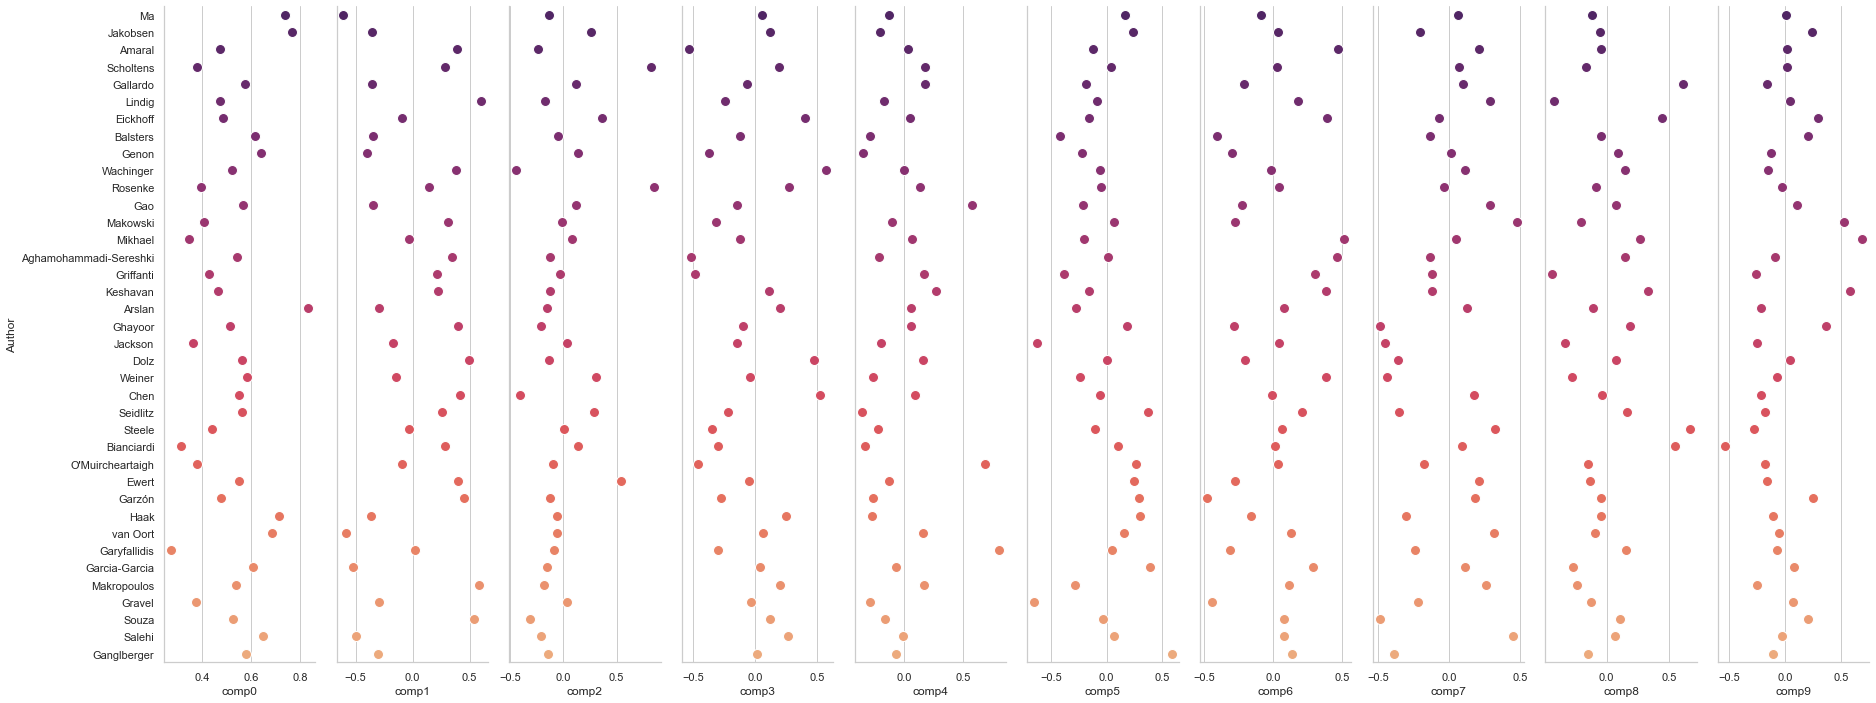

In [29]:
# Now make a plot
import seaborn as sns
sns.set_theme(style="whitegrid")
df_X = pd.DataFrame(data=np.concatenate([data['Author'].to_numpy().reshape([38, 1]), X], axis=1), 
                    columns= np.concatenate([['Author'],[f'comp{d}' for d in range(10)]]))
g = sns.PairGrid(df_X,
                 x_vars=df_X.columns[1:], y_vars=["Author"],
                 height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Parcellate the papers

Now that the content of each paper has been condensed into only 10 (hopefully informative) numbers, we can run these features into a trusted, classic parcellation algorithm: Ward's agglomerative hierarchical clustering, as implemented in the scipy library. We cut the hierarchy to extract 7 "paper parcels", and also use the hierarchy to re-order the papers, such that similar papers are close in order, as illustrated in a dendrogram representation. 

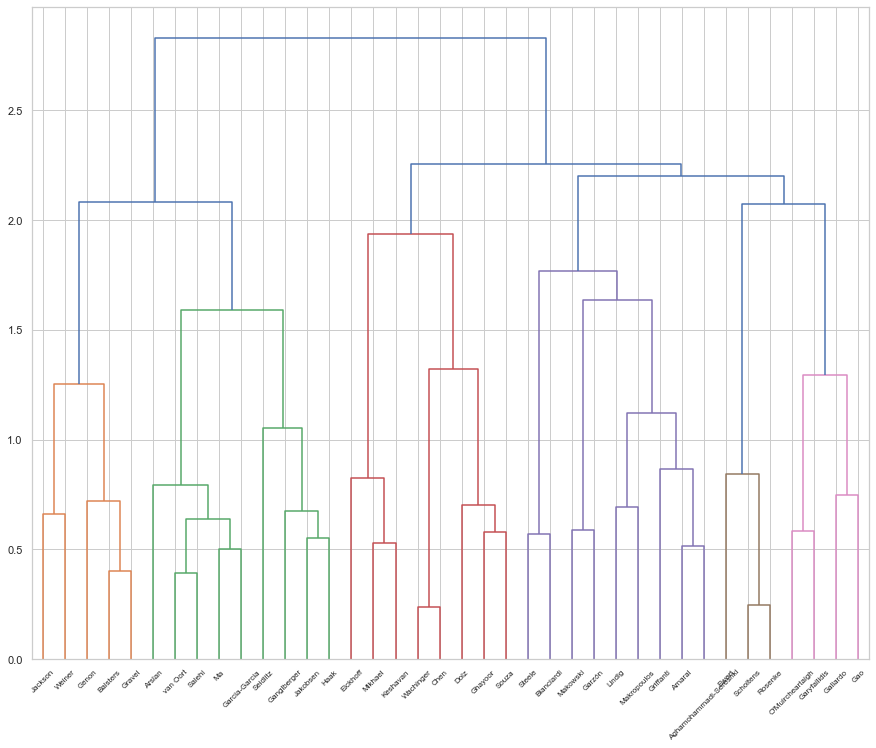

In [41]:
n_clusters = 7 # Set the number of clusters

# Make figures nice and big
fig_size = [15,12] 
plt.rcParams["figure.figsize"] = fig_size 

Xd = pd.DataFrame(X,index=range(0,data.shape[0])) # Convert the data to a pandas frame
hier = linkage(Xd, method='ward', metric='euclidean') # scipy's hierarchical clustering
res = dendrogram(hier, labels=data['Author'].to_numpy(), get_leaves=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on papers from the dendrogram

# Cut the hierarchy and turn the parcellation into a dataframe
part = np.squeeze(cut_tree(hier,n_clusters=n_clusters))
part = pd.DataFrame(data=part[order],columns=["Parcel"],index=order)
plt.show()


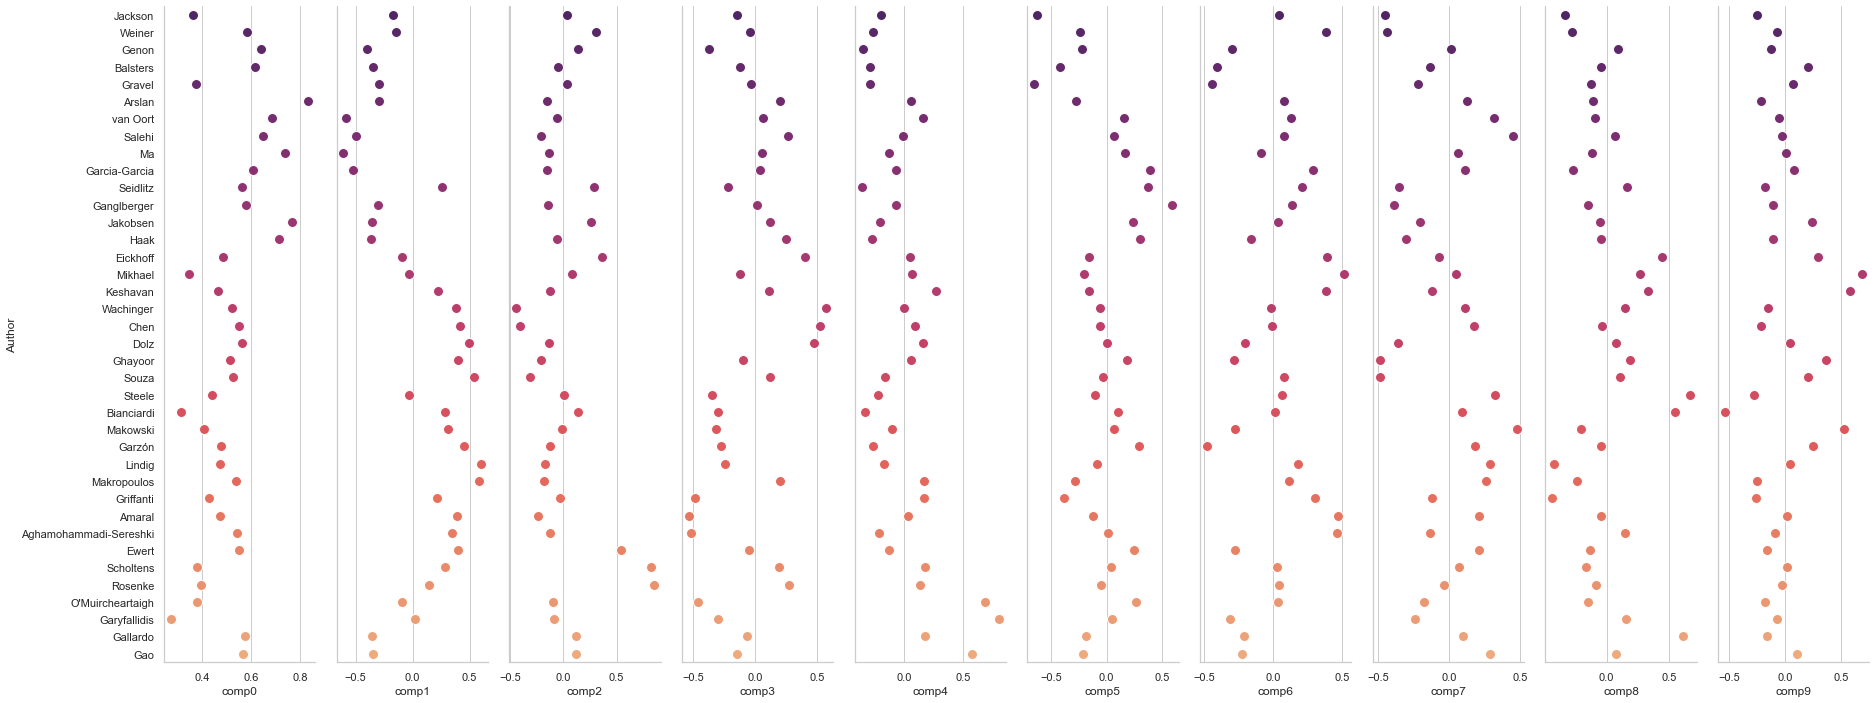

In [44]:
# Now make a plot
import seaborn as sns
sns.set_theme(style="whitegrid")
g = sns.PairGrid(df_X.iloc[order],
                 x_vars=df_X.columns[1:], y_vars=["Author"],
                 height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Plot the similarity matrix with the parcels

So, to get a better feel of the similarity between papers that was fed into the clustering procedure, we extracted the 38x38 (papers x papers) correlation matrix across features. Papers are re-ordered in the matrix according to the above hierarchy. Each "paper parcel" has been indicated by a black square along the diagonal, which represents the similarity measures between papers falling into the same parcel. 

/tmp/ipykernel_25604/4135296032.py:17: DeprecationWarning: scipy.unique is deprecated and will be removed in SciPy 2.0.0, use numpy.unique instead
  val , ind = scipy.unique(part,return_index=True)
/tmp/ipykernel_25604/4135296032.py:18: DeprecationWarning: scipy.sort is deprecated and will be removed in SciPy 2.0.0, use numpy.sort instead
  ind = scipy.sort(ind)


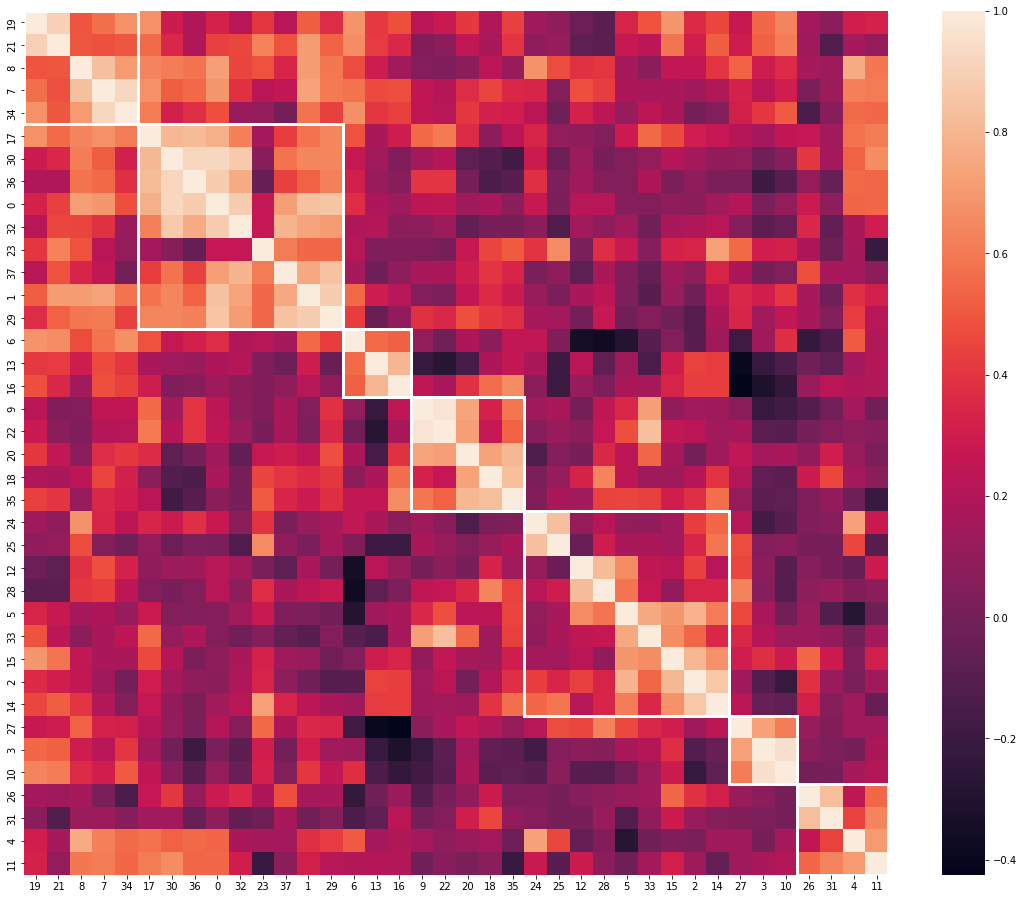

In [6]:
# Initialize figure/axes
fig = plt.figure()
plt.clf()
ax = fig.add_axes([0,0,1,1])

# Generate and reorder the correlation matrix
R = Xd.transpose().corr()
Rs = R.iloc[order,order]
n = len(order)

# Show the matrix with seaborn
sns.heatmap(Rs, square=True )

# I somehow have not been able to find a good tool to do that
# So a bit of an ugly hack to add diagonal squares
# that highlight each cluster
val , ind = scipy.unique(part,return_index=True)
ind = scipy.sort(ind)
ind = np.append(ind,Rs.shape[0])
ind = ind
for ii in range(0,ind.shape[0]-1):
    p = matplotlib.patches.Rectangle((ind[ii+1] , ind[ii+1]),
                                             ind[ii]-ind[ii + 1],
                                             ind[ii]-ind[ii + 1],
                                             angle=0, 
                                             edgecolor='white',
                                             facecolor='none' ,
                                             linewidth=3)
    ax.add_patch(p)
plt.show()

# Represent the paper parcels in a table

Now, each paper of the special issue has been assigned to one and only one out of 7 possible "paper parcel". Let's list the papers together with their parcels:

In [7]:
tab = data.iloc[order] # re-order the papers using the hierarchical clustering
tab = tab[['Article', 'Author']] # keep only the article title and authors 
tab = pd.concat([part,tab],axis=1) # Merge with the parcel numbers
tab.style # display the table

,Parcel,Article,Author
19,5,An emergent functional parcellation of the temporal cortex,Jackson
21,5,Defining the most probable location of the parahippocampal place area using cortex-based alignment and cross-validation,Weiner
8,5,The heterogeneity of the left dorsal premotor cortex evidenced by multimodal connectivity-based parcellation and functional characterization,Genon
7,5,Connectivity-based parcellation reveals distinct cortico-striatal connectivity fingerprints in Autism Spectrum Disorder,Balsters
34,5,Phase-synchronization-based parcellation of resting state fMRI signals reveals topographically organized clusters in early visual cortex.,Gravel
17,0,Human Brain Mapping: A Systematic Comparison of Parcellation Methods for the Human Cerebral Cortex,Arslan
30,0,Functional parcellation using time courses of instantaneous connectivity,van Oort
36,0,An Exemplar-based Approach to Individualized Parcellation Reveals the Need for Sex Specific Functional Networks,Salehi
0,0,Functional atlas of the awake rat brain: a neuroimaging study of rat brain specialization and integration,Ma
32,0,Detecting stable individual differences in the functional organization of the human striatum,Garcia-Garcia


# Show the dominant features (words) for each parcel

For each paper parcel, we can evaluate which words contribute more to the dominant component associated with that parcel.

In [8]:
max_comp = 2 # Number of components to examine
max_words = 10 # Number of words to include per component
# Compute the average / std across all components
gavg = Xd.transpose()
gavg_mean = gavg.mean(axis=1)
gavg_std = gavg.std(axis=1)

# Initialize a frame to store the dominant words for each parcel
all_comp = []
words = pd.DataFrame(columns=["Parcel","word","weight"])
nb_words = 0

for cc in range(0,n_clusters): # Loop over parcels
    avg = Xd[part.Parcel==cc] # average components inside the parcel
    
    # Normalize from the grand average
    avg = avg.transpose()
    avg = avg.mean(axis=1)
    avg = np.divide((avg-gavg_mean),gavg_std)
    
    # Look for the component with highest contributions
    # There could in theory be components with negative contributions as well
    # In practice here this never happens
    val_avg , ind_avg = np.unique(-  avg ,return_index=True)
    for pos in range(0,max_comp): # We will look at the top components only
        val , ind = np.unique(- svd.components_[ind_avg[pos]],return_index=True) # Rank the components
        ind = ind[0:max_words] # Just retain the first 6 words
        for ww in ind: # Add the words and associated parcels / weights to the table
            nline = pd.DataFrame([[cc,fts[ww],np.round(100*svd.components_[ind_avg[0]][ww])]],
                            columns=["Parcel","word","weight"],
                            index=[nb_words])
            words = pd.DataFrame.append(words,nline)
            nb_words = nb_words+1
words

/tmp/ipykernel_25604/2731871188.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg = Xd[part.Parcel==cc] # average components inside the parcel


,Parcel,word,weight
0,0,functional,27.0
1,0,connectivity,22.0
2,0,parcellation,20.0
3,0,segmentation,19.0
4,0,network,16.0
...,...,...,...
135,6,methods,1.0
136,6,images,-3.0
137,6,manual,-3.0
138,6,years,-3.0


This table is a bit big, let's replace it by word clouds. We will shape each cloud as the corresponding parcel number, starting with one instead of 0, because maths.

<Figure size 1080x864 with 0 Axes>

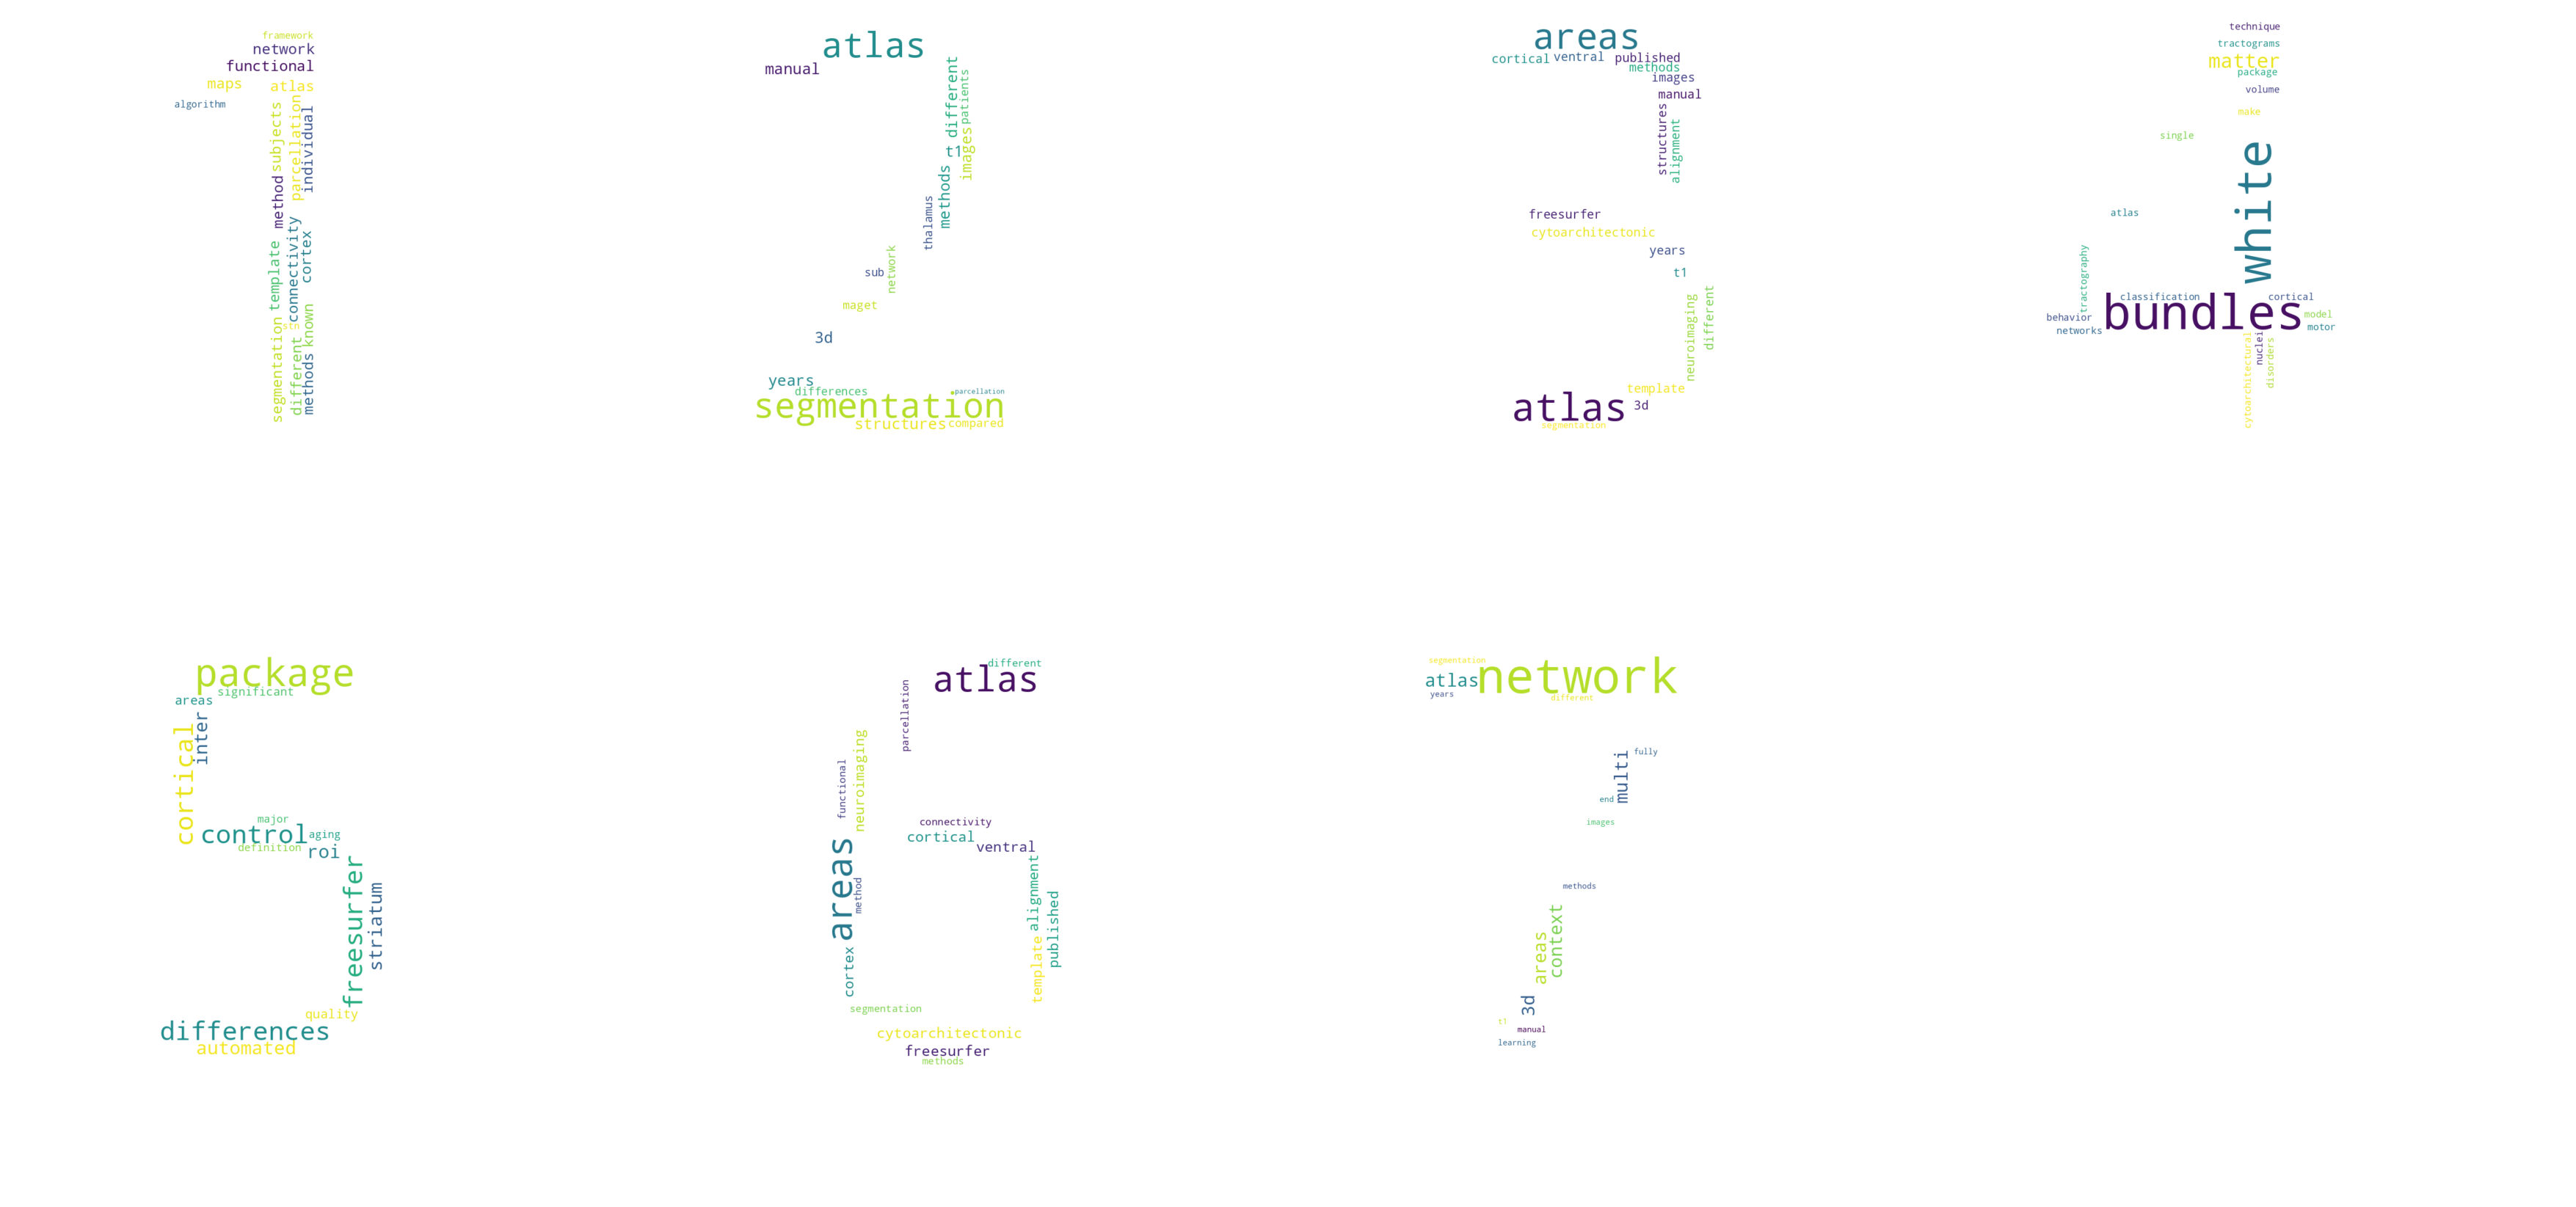

In [9]:
plt.clf()
word_width = 1000
word_height = 1000 
fig = plt.figure(figsize=(15, 7), dpi=300)
for pp in range(0,int(words["Parcel"].max())+1): # Loop over parcels
    dd = {}
    ind = words.loc[words["Parcel"]==pp].index # Select the words in selected parcel
    
    # Create a dictionary, where each word is associated to its weight
    for ii in ind:
        dd[words["word"][ii]] =  (words["weight"][ii] / words["weight"][ind[0]]) 
        
    # Create an image with just a number (1, 2, ...)
    # This will be used to shape the word cloud
    # We use the package WordCloud itself for this, because it ships with fonts and can generate images...
    # Again this is a terrible hack
    img = np.array( 
        WordCloud(
            background_color="white",
            max_font_size=1500,
            height=word_height,
            width=word_width,
            stopwords="None"
        ).generate_from_frequencies({str(pp+1): 1}).to_image()
    )
    
    # Generate the word cloud
    wordcloud = WordCloud(
        background_color="white",
        random_state=0,
        relative_scaling=0,
        max_font_size=400,
        height=word_height,
        width=word_height,
        mask=img
    ).generate_from_frequencies(dd)
    
    # Show the figure
    plt.subplot(2, 4, pp+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
plt.show()

# Conclusion 

By checking the word clouds and the titles, the paper parcels are pretty clear. The editorial we wrote based this analysis goes through all the papers for each category. 